# (1.) ตรวจจับวัตถุด้วย YOLO v3

- โหลด YOLOv3-320 ทั้งไฟล์ cfg, weights จาก https://pjreddie.com/darknet/yolo/ โดย ไฟล์ cfg ให้เลือก Raw -> Save as -> ตั้งชื่อไฟล์ "yolov3.cf"
- โหลด coco.names จาก https://github.com/pjreddie/darknet/blob/master/data/coco.names แล้วให้เลือก Raw -> Save as -> ตั้งชื่อไฟล์ "coco.names"

การตั้งชื่อไฟล์ ต้องมี "..." ด้วย

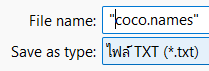

ใช้ OpenCV และเรียกใช้ Yolo

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
cv2.__version__

In [ ]:
# โหลด YOLO
net = cv2.dnn.readNet("/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/yolov3.weights",
                      "/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/yolov3.cfg")    # read file
net

In [ ]:
# สร้าง List เก็บรายชื่อคลาส โดยอ่านจากไฟล์ coco.names
classes = []
with open('/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/coco.names', 'r') as f:
  classes = [line.strip() for line in f.readlines()]    # ข้อมูล List (รายการคลาส)

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

len(classes)    # Model มี 80 คลาส

In [ ]:
layer_names

In [ ]:
net.getUnconnectedOutLayers()

In [ ]:
output_layers

ดูว่ามีคลาสอะไรบ้าง จะพบว่า Model จำแนกคลาส person, bicycle, car, motobike, bus, ... ได้

In [ ]:
classes[:10]

เพื่อให้การตีกรอบวัตถุ (Bouning box) มีการแยกสีให้แตกต่างกัน จึงสร้างค่าสุ่มสีดังนี้

In [ ]:
# ศร้างค่าสีแบบสุ่ม เพื่อเขียนกรอบสี่เหลี่ยมรอบวัตถุ (Bounding box)
colors = np.random.uniform(0, 255, size=(len(classes), 3))

ทำการโหลดภาพเพื่อตรวจจับวัตถุ (detect)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/deep_greenbook/image/markWein.jpg')

# หากภาพมีขนาดใหญ่ ให้ย่อด้วยสเกล fx fy
# img = cv2.resize(img, None, fx=0.8, fy=0.8)

cv2_imshow(img)

In [ ]:
img.shape   # height, width, channels

ทำการตรวจจับ

In [ ]:
img_size = (320, 320)   # ตามขนาด YOLO weight ที่โหลดมา
blob = cv2.dnn.blobFromImage(img, 1/255, img_size, (0, 0, 0), True, crop=False)
net.setInput(blob)    # ป้อนอินพุตภาพ
outputs = net.forward(output_layers)

outputs

ทำการตรวจจับเรียบร้อยแล้ว ผลลัพธ์ค่าต่างๆ จะอยู่ที่ outputs

เพื่อให้รู้ว่าวัตถุคืออะไร อยู่ตำแหน่งใด ให้วนรอบอ่านค่าจาก outputs

In [ ]:
class_ids = []
confidences = []
boxes = []
height, width = img.shape[0], img.shape[1]
for out in outputs:
  for detec in out:
    scores = detec[5:]    # ค่า Score หรือ Confidence ที่ทำนายวัตถุ เช่น [c1 c2 c3 ... c80]
    class_id = np.argmax(scores)    # ค่า Score สูงสุดวัตถุนั้น ตกอยู่ในคลาสไหน
    confidence = scores[class_id]
    if confidence > 0.5:    # ถ้าค่าความเชื่อมั่น > 0.5 ถือว่าน่าจะใช่คลาสที่สนใจ
      center_x = int(detec[1] * width)   # จุดศูนย์กลางวัตถุ x, y
      center_y = int(detec[2] * height)

      w = int(detec[3] * width)   # ความกว้าง w, ความสูง h ของกรอบสี่เหลี่ยม
      h = int(detec[4] * height)

      x = int(center_x - w / 2)   # จุด coordinate สำหรับตีกรอบขอบเขต
      y = int(center_y - h / 2)

      boxes.append([x, y, w, h])  # เก็บ list ไว้พล็อต
      confidences.append(float(confidence))   # ค่าความเชื่อมั่น (%)
      class_ids.append(class_id)    # วัตถุเป็นคลาสอะไร

# คัดเลือกขอบเขตที่ดีที่สุด (Non-MAx Suppresion : NMX) เพื่อลดการซ้อนกันของกรอบ
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [ ]:
indices

In [ ]:
class_ids

In [ ]:
confidences

In [ ]:
boxes

หลังจากตรวจจับและคัดเลือกขอบเขตแล้ว ทำการเขียนเส้นกรอบขอบเขต (ฺBoundary box) กำกับ พร้อมกับชื่อคลาส (Class name) และค่าความเชื่อมั่น (Confidence)

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX   # รูปแบบ font
text_color = (255, 255, 255)    # สี

for i in range(len(boxes)):   # วนนอบตามจำนวนขอบเขตที่ตรวจจับได้
  if i in indices:
    x, y, w, h = boxes[i]
    label = str(classes[class_ids[i]])
    conf = confidences[i]     # ค่าความเชื่อมั่น
    label = '{} {:.1f}%'.format(label, conf*100)    # ข้อความที่เขียนกำกับ
    color = colors[i]   # สุ่มสี แต่ละ loop

    t_size = cv2.getTextSize(label, font, 1, 1)[0]    # คำนวณหาขนาด Text
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)    # Bounding Box

    c2 = x + int(t_size[0]*0.8), y-int(t_size[1]*1.2)   # จุดพิกัดทแยง เพื่อเขียนเส้นทึบ
    cv2.rectangle(img, (x,y-2), c2, color, -1)    # bckground สำหรับ Label
    cv2.putText(img, label, (x, y-2), font, 0.7, text_color, 3)   # ข้อความ Text

cv2_imshow(img)   # แสดงผล
cv2.waitKey(0)    # กดแป้นใดๆ เพื่อปิดหน้าต่าง
cv2.destroyAllWindows()

# (2) ตรวจจับวัตถุใน VDO

ตรวจจับวัตถุใน VDO โดยใช้ OpenCV และ YOLO v3 หลักการคือ OpenCV เปิดเล่น VDO แล้วโหลดภาพนิ่งแต่ละเฟรม จากนั้นป้อนภาพนิ่งเข้าสู่การตรวจจับ ตัวโปรแกรมหลัก ทำคล้ายกับ workshop ที่ผ่านมา

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# ตั้งค่า
colorGreen = (0, 255, 0)    # สีเขียว
scale = 0.75      # สเกลย่อ
img_size = (320, 320)     # ขนาด (ให้ตรงกับ weight YOLO ที่ดาวน์โหลด)
confThreshold = 0.5   # ค่า Threshold
nmsThreshold = 0.4   # ค่า NMS Threshold

cap = cv2.VideoCapture('/content/drive/MyDrive/deep_greenbook/image/expressway.avi')    # กรณีตรวจจับไฟล์
cap.set(3, 640)   # Width
cap.set(4, 480)   # Height

if (not(cap.isOpened())):   # ถ้าเปิดไฟล์หรือกล้อง (Source) ไม่ได้
  print("Could not open the VDO file")    # ให้แจ้งเตือน

classesFile = '/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/coco.names'
classNames = []
with open(classesFile, "r") as f:
  classNames = [line.strip() for line in f.readlines()]

modelConfiguration = '/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/yolov3.cfg'     # Yolo
modelWeights = '/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/yolov3.weights'

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
layerNames = net.getLayerNames()
output_layers = [layerNames[i - 1] for i in net.getUnconnectedOutLayers()]

# ฟังก์ชันเขียนเส้นกรอบรอบวัตถุ
def locateObjects(outputs, img):
  hT, wT, cT = img.shape
  bbox = []
  classIds = []
  confs = []

  for out in outputs:
    for det in out:
      scores = det[5:]
      classId = np.argmax(scores)
      confidence = scores[classId]
      if confidence > confThreshold:
        w, h = int(det[3] * wT), int(det[4] * hT)
        x, y = int((det[0] * wT) - w / 2),  int((det[1] * hT) - h / 2)

        bbox.append([x, y, w, h])
        confs.append(float(confidence))
        classIds.append(classId)
  indices = cv2.dnn.NMSBoxes(bbox, confs, confThreshold, nmsThreshold)

  for i in indices:
    box = bbox[i]
    x, y, w, h = box[0], box[1], box[2], box[3]
    cv2.rectangle(img, (x, y), (x + w, y + h), colorGreen, 2)
    label = str(classNames[classIds[i]])
    label = '{} {:.1f}%'.format(label, confs[i]*100)
    cv2.putText(img, label, (x, y-8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, colorGreen, 2)

In [ ]:
# Main Loop
while (cap.isOpened()):   # วนรอบเปิด VDO/กล้อง เพื่ออ่านเฟรม
  success, img = cap.read()   # img คือ เฟรมภาพ (frame)
  bob = cv2.dnn.blobFromImage(img, 0.00392, img_size, (0, 0, 0), True, crop=False)    # 0.00392 = 1/255
  net.setInput(bob)    # Detect
  outputs = net.forward(output_layers)
  locateObjects(outputs, img)   # เขียนเส้นตีกรอบวัตถุ

  cv2_imshow(img)
  if cv2.waitKey(1) == 27:    # ESC to exit
    break
# กรณีสิ้นสุด ให้คืนทรัพยากร
cap.release()   # เคลียร์ object
cv2.destroyAllWindows()   # ปิดหน้าต่าง

รันใน PC ดีกว่า

# (3.) ใช้กล้องสด

แก้โค้ดให้เป็น cap = cv2.VideoCapture(0) แต่เนื่องจากโค้ดที่เขียนไปนี้ ใช้ได้แค่ใน PC ก็ไปดูlink ข้างล่างเพิ่มเติมเองต่อ

https://colab.research.google.com/github/isnamdnazim/YOLO-V4-Object-Detection/blob/main/Real_time_YOLOv4_Object_Detection_on_Webcam_in_Google_Colab_%7C_Images_and_Video.ipynb#scrollTo=1Eq_XpiU3IE3

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# ตั้งค่า
colorGreen = (0, 255, 0)    # สีเขียว
scale = 0.75      # สเกลย่อ
img_size = (320, 320)     # ขนาด (ให้ตรงกับ weight YOLO ที่ดาวน์โหลด)
confThreshold = 0.5   # ค่า Threshold
nmsThreshold = 0.4   # ค่า NMS Threshold

cap = cv2.VideoCapture(0)    # ***ใช้ webcam***
cap.set(3, 640)   # Width
cap.set(4, 480)   # Height

if (not(cap.isOpened())):   # ถ้าเปิดไฟล์หรือกล้อง (Source) ไม่ได้
  print("Could not open the VDO file")    # ให้แจ้งเตือน

classesFile = '/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/coco.names'
classNames = []
with open(classesFile, "r") as f:
  classNames = [line.strip() for line in f.readlines()]

modelConfiguration = '/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/yolov3.cfg'     # Yolo
modelWeights = '/content/drive/MyDrive/deep_greenbook/model_file/11_objDetec/yolov3.weights'

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
layerNames = net.getLayerNames()
output_layers = [layerNames[i - 1] for i in net.getUnconnectedOutLayers()]

# ฟังก์ชันเขียนเส้นกรอบรอบวัตถุ
def locateObjects(outputs, img):
  hT, wT, cT = img.shape
  bbox = []
  classIds = []
  confs = []

  for out in outputs:
    for det in out:
      scores = det[5:]
      classId = np.argmax(scores)
      confidence = scores[classId]
      if confidence > confThreshold:
        w, h = int(det[3] * wT), int(det[4] * hT)
        x, y = int((det[0] * wT) - w / 2),  int((det[1] * hT) - h / 2)

        bbox.append([x, y, w, h])
        confs.append(float(confidence))
        classIds.append(classId)
  indices = cv2.dnn.NMSBoxes(bbox, confs, confThreshold, nmsThreshold)

  for i in indices:
    box = bbox[i]
    x, y, w, h = box[0], box[1], box[2], box[3]
    cv2.rectangle(img, (x, y), (x + w, y + h), colorGreen, 2)
    label = str(classNames[classIds[i]])
    label = '{} {:.1f}%'.format(label, confs[i]*100)
    cv2.putText(img, label, (x, y-8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, colorGreen, 2)

In [ ]:
# Main Loop
while (cap.isOpened()):   # วนรอบเปิด VDO/กล้อง เพื่ออ่านเฟรม
  success, img = cap.read()   # img คือ เฟรมภาพ (frame)
  bob = cv2.dnn.blobFromImage(img, 0.00392, img_size, (0, 0, 0), True, crop=False)    # 0.00392 = 1/255
  net.setInput(bob)    # Detect
  outputs = net.forward(output_layers)
  locateObjects(outputs, img)   # เขียนเส้นตีกรอบวัตถุ

  cv2_imshow(img)
  if cv2.waitKey(1) == 27:    # ESC to exit
    break
# กรณีสิ้นสุด ให้คืนทรัพยากร
cap.release()   # เคลียร์ object
cv2.destroyAllWindows()   # ปิดหน้าต่าง

# (4.) YOLO บน Colab

## เตรียมการ

In [ ]:
!nvidia-smi   # ตรวจสอบ environment ของ GPU

อิมพอร์ต torch แล้วโชว์เวอร์ชัน และตรวจสภาพแวดล้อม

In [ ]:
import torch

print(f"Setup Complete: Using torch {torch.__version__}")
print(f"{torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'}")

## สร้าง Model และตรวจจับ

สร้าง Model โดยโหลด Weight YOLOv5 (ที่ Train ไว้แล้ว) จากนั้นทำการตรวจจับโดยป้อนอินพุตเป็น URL ไฟล์บนเว็บ

In [ ]:
# โหลด Model โดยอัตโนมัติ
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# ไฟล์ image ที่ต้องการตรวจจับ
img_uri = "https://ultralytics.com/images/bus.jpg"

# ทำการตรวจจับ (Inference) และพิมพ์แสดงผล
results = model(img_uri)
results.print()

image 1/1 บอกว่าประอบด้วยวัตถุอะไรบ้าง จำนวนเท่าใด ส่วน Speed คือความเร็วในการประมวลผล

ถ้าต้องการดูค่าต่างๆของวัตถุ เช่น พิกัดทแยงกรอบรอบวัตถุ ค่าความเชื่อมั่น (Score หรือ confidence) ID ของคลาส และชื่อคลาส

In [ ]:
results.pandas().xyxy[0]    # img1 predictions (pandas)

หากต้องการค่าของวัตถุใด ให้เลือกแบบ Slicing แล้วระบุชื่อคอลัมน์ เช่น ต้องการค่า xmin, ymin ของวัตถุลำดับแรก ให้ระบุ [0:1]

In [ ]:
print(results.pandas().xyxy[0][0:1].xmin)   # ค่า xmin
print(results.pandas().xyxy[0][0:1].ymin)   # ค่า ymin

ถ้าต้องการดูค่าต่างๆของวัตถุ ในรูปแบบเมทริกซ์ (Tensor)

In [ ]:
results.xyxy[0]

## ตีกรอบ Bounding box

จากที่ผ่านมา ระบบทำการตรวจจับ (Detect object) แล้วให้ข้อมูลของวัตถุ ซึ่งยังไม่มีการเขียนเส้นตีกรอบแต่อย่างใด อย่างไรก็ตาม โดยทั่วไปักจะดูว่าผลลัพธ์มีวัตถุอะไร อยู่ตำแหน่งใด ค่าความเชื่อมั่นเป็นเท่าใด ฯลฯ ก็ต้องนำข้อมูลมาเขียนเส้นกรอบ Bounding box และเขียน Label กำกับ

In [ ]:
from urllib.request import urlopen    # ไลบารีเปิดไฟล์บนเว็บ (Request)
from PIL import Image     # ไลบารี Pillow สำหรับทำงานกับภาพ

img = Image.open(urlopen(img_uri))    # เปิดภาพที่เป็นอินพุต (ที่ให้ระบบทำการตรวจจับ)
img

In [ ]:
from PIL import Image, ImageFont, ImageDraw

i = 2   # ลำดับ index ของวัตถุที่ตรวจจับได้
# ค่าพิกัด Coordinate จุดทแยง 2 จุด (ตีกรอบรอบวัตถุ)
p1 = (results.pandas().xyxy[0][i:i+1].xmin, results.pandas().xyxy[0][i:i+1].ymin)
p2 = (results.pandas().xyxy[0][i:i+1].xmax, results.pandas().xyxy[0][i:i+1].ymax)

draw = ImageDraw.Draw(img, "RGBA")    # เตรียมเขียนทับภาพ (Overlay)
draw.rectangle((p1, p2), outline=(200, 255, 200, 200), width=8)   # เขียนกรอบสี่เหลี่ยม

font = ImageFont.truetype('Humor-Sans.ttf', 50)       # ตั้งค่า font
conf = results.pandas().xyxy[0][i:i+1].confidence[i]    # ค่าความเชื่อมั่น
conf_txt = ' {:.1f}%'.format(conf*100)    # string ในรูปแบบ nn.n%
label = results.pandas().xyxy[0][i:i+1].name[i] + conf_txt    # ข้อความ label กำกับวัตถุ
draw.text((p1[0]+10,p1[1]), label, font=font, align='left')   # เขียน label กำกับ

img    # แสดงภาพที่ตีกรอบและ label แล้ว

อ่านข้อมูล (results) ที่ผ่านการตรวจจับ แล้วเขียนกำกับลงในตำแหน่งวัตถุ ซึ่งตัวอย่างนี้ใช้ค่า i เป็นลำดับ index ของวัตถุ เช่น i=0 คือวัตถุที่ตรวจจับได้เป็นลำดับแรก

ลองเปลี่ยน i เป็นค่าอื่นๆ

In [ ]:
from PIL import Image, ImageFont, ImageDraw

i = 3   # ลำดับ index ของวัตถุที่ตรวจจับได้
p1 = (results.pandas().xyxy[0][i:i+1].xmin, results.pandas().xyxy[0][i:i+1].ymin)
p2 = (results.pandas().xyxy[0][i:i+1].xmax, results.pandas().xyxy[0][i:i+1].ymax)

draw = ImageDraw.Draw(img, "RGBA")
draw.rectangle((p1, p2), outline=(200, 255, 200, 200), width=8)

font = ImageFont.truetype('Humor-Sans.ttf', 50)
conf = results.pandas().xyxy[0][i:i+1].confidence[i]
conf_txt = ' {:.1f}%'.format(conf*100)
label = results.pandas().xyxy[0][i:i+1].name[i] + conf_txt
draw.text((p1[0]+10,p1[1]), label, font=font, align='left')

img

ถ้าทำต่อกัน ภาพจะถูกเขียนซ้ำกัน

# (6.) YOLO detect.py บน Colab

ใช้ YOLOv5 ตรวจจับและทำการตีกรอบให้อัตโนมัติ (ใช้ไฟล์ weight ที่ Train ไว้แล้ว) โดยจะตีกรอบให้ทุกวัตถุที่ตรวจพบ สามารถอินพุตเป็นภาพนิ่ง ภาพสดๆจากกล้อง หรือเป็นวิดิโอออนไลน์จาก Youtube ก็ได้ (ใส่อินพุตเป็น URL ของวิดิโอ) เพื่อให้ง่ายต่อการ Implement จะใช้ Colab อย่าลืมตั้งค่าให้รันบน GPU เสียก่อน

ทำการ Clone ไฟล์โฟลเดอร์ทั้งหมดมาไว้ที่พื้นที่บน Colab

## เตรียมการ

In [ ]:
!nvidia-smi   # ตรวจสอบ environment ของ GPU

In [ ]:
!git clone https://github.com/ultralytics/yolov5    # ทำการ Clone

จะพบว่ามีโฟลเดอร์ yolo5 แล้ว

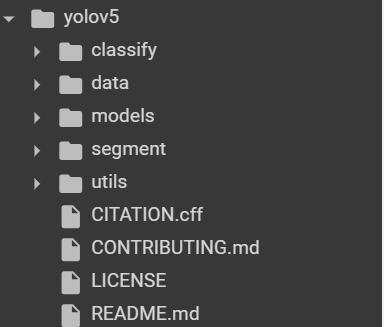

ทำการติดตั้งไลบารีต่างๆที่จำเป็นสำหรับ YOLOv5

In [ ]:
%pip install -qr /content/yolov5/requirements.txt

In [ ]:
# โหลด Model โดยอัตโนมัติ
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [ ]:
import torch

print(f"Setup Complete: Using torch {torch.__version__}")
print(f"{torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'}")

## ใช้งาน

ใน yolo ที่ clone มาจะมีไฟล์อินพุตตัวอย่างให้ทดสอบ อยู่ใน dat/images

In [ ]:
%ls /content/yolov5/data/images

ทำการตรวจจับ โดยสั่งรันไฟล์ detect.py ซึ่งเป็นไฟล์หลักในการตรวจจับ รันกำหนดค่าพารามิเตอร์ต่างๆดังนี้
- weughts yolov5s.pt
- ขนาด Image size 640
- conf 0.25 (ถ้าค่าความเชื่อมั่น 0.25 หรือ 25% ขึ้นไปก็ให้ถือว่าตรวจจับได้) ซึ่งถ้าค่าน้อยผลลัพธ์จะมีความผิดพลาดสูง ลองตั้งค่าให้สูงขึ้นได้
- source แหล่งอินพุตที่จะให้ระบบตรวจจับ ในที่นี้มี 2 ภาพ คือ bus.jpg และ zidane.jpg

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5s.pt --img 640 --conf 0.25 --source /content/yolov5/data/images

หลังตรวจจับ ระบบจะเก็บภาพ (ที่ตีกรอบ) ไว้ในโฟลเดอร์ runs/detect/exp สามารถนำมาแสดงดังนี้

In [ ]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp/bus.jpg', width=400)

In [ ]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp/zidane.jpg', width=400)

โดยรวมระบบมีความแม่นยำที่ดีพอสมควร

YOLOv5-P5 models Train ที่ --img 640 มีตัวเลือก Weight อื่นๆ (s m l x เรียงจากเล็กไปใหญ่) ได้แก่ yolov5s.pt yolov5m.pt yolov5l.pt yolov5x.pt

YOLOv5-P6 models Train ที่ --img 1280 มีตัวเลือก Weight อื่นๆ ได้แก่ yolov5s6.pt yolov5m6.pt yolov5l6.pt yolov5x6.pt

ลองใช้วิดิโอจากใน drive

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5s.pt --conf 0.4 --source /content/drive/MyDrive/deep_greenbook/image/expressway.avi

จะเห็นว่าได้ผลลัพธ์เป็น frameๆ

In [ ]:
%pylab inline
import cv2
from IPython.display import clear_output

# Grab the input device, in this case the webcam
# You can also give path to the video file
vid = cv2.VideoCapture("/content/yolov5/runs/detect/exp2/expressway.mp4")

# Put the code in try-except statements
# Catch the keyboard exception and
# release the camera device and
# continue with the rest of code.
try:
    while(True):
        # Capture frame-by-frame
        ret, frame = vid.read()
        if not ret:
            # Release the Video Device if ret is false
            vid.release()
            # Message to be displayed after releasing the device
            print("Released Video Resource")
            break
        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Turn off the axis
        axis('off')
        # Title of the window
        title("Input Stream")
        # Display the frame
        imshow(frame)
        show()
        # Display the frame until new frame is available
        clear_output(wait=True)
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()
    # Message to be displayed after releasing the device
    print("Released Video Resource")


ได้ผลลัพธ์ดังนี้

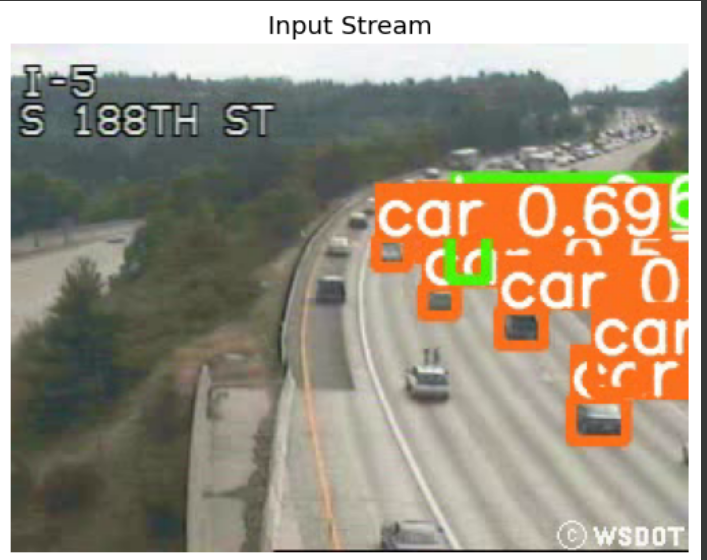

ดูโค้ดการโชว์วิดิโอได้ที่นี่ https://github.com/bikz05/ipython-notebooks/blob/master/computer-vision/displaying-video-in-ipython-notebook.ipynb

อัปโหลดไฟล์เข้าไปที่ content ที่โค้ดนี้

In [ ]:
from google.colab import files
uploaded = files.upload()

กรณีใช้วิดิโอจาก Youtube เป็นอินพุต ให้ก๊อปปี้ URL มาจาก YouTube แล้วกำหนดเป็น source

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5s.pt --img 640 --conf 0.4 --source 'https://youtu.be/NSk27elArTI?si=3G4de6JXDmKVKpUE'

In [ ]:
%pylab inline
import cv2
from IPython.display import clear_output

# Grab the input device, in this case the webcam
# You can also give path to the video file
vid = cv2.VideoCapture("/content/yolov5/runs/detect/exp3/NSk27elArTI_si_3G4de6JXDmKVKpUE.mp4")

# Put the code in try-except statements
# Catch the keyboard exception and
# release the camera device and
# continue with the rest of code.
try:
    while(True):
        # Capture frame-by-frame
        ret, frame = vid.read()
        if not ret:
            # Release the Video Device if ret is false
            vid.release()
            # Message to be displayed after releasing the device
            print("Released Video Resource")
            break
        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Turn off the axis
        axis('off')
        # Title of the window
        title("Input Stream")
        # Display the frame
        imshow(frame)
        show()
        # Display the frame until new frame is available
        clear_output(wait=True)
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()
    # Message to be displayed after releasing the device
    print("Released Video Resource")


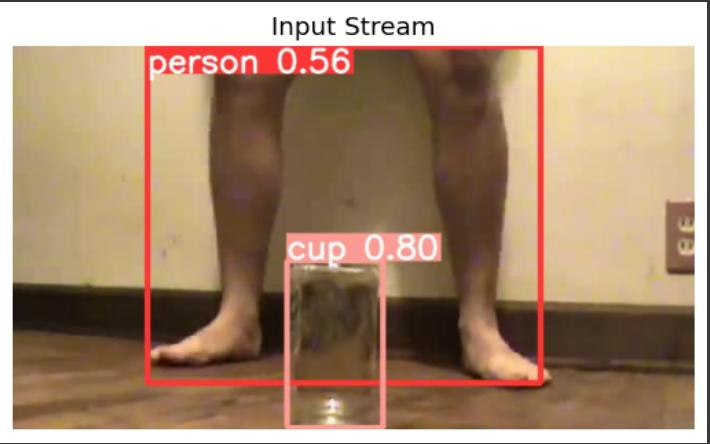

หมด Seesion ที่ Clone มาหายหมด

# (9.) Train Yolo ด้วย Dataset coco128

โหลด dataset จากที่นี่ https://www.kaggle.com/datasets/ultralytics/coco128 ทำการคลาย zip แล้วอัปโหลดเข้า drive

ทำการ **Train** ทำตาม workshop 6

In [ ]:
!nvidia-smi   # ตรวจสอบ environment ของ GPU

In [ ]:
import torch

print(f"Setup Complete: Using torch {torch.__version__}")
print(f"{torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'}")

In [ ]:
# โหลด Model โดยอัตโนมัติ
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [ ]:
!git clone https://github.com/ultralytics/yolov5    # ทำการ Clone

In [ ]:
%pip install -qr /content/yolov5/requirements.txt   # install dependencies

การ Train ในที่นี้คือสั่งรันไฟล์ train.py โดยพารามิเตอร์มีดังนี้
- data: ไฟล์ที่กำหนดรายละเอียดพาธและรายชื่อคลาสที่ใช้ Train (อยู่ในโฟลเดอร์ yolo/data)
- cfg: ขนาดของสถาปัตยกรรม เช่น s m l ... แนะนำให้ใช้ s เพราะใช้เวลาน้อยสุด
- weights: ไฟล์ Pre-trained ที่โหลดมา คือ yolov5.pt
- batch-size, epochs เหมือนนับ CNN

In [ ]:
!python /content/yolov5/train.py --data /content/yolov5/data/coco128.yaml --cfg /content/yolov5/models/yolov5s.yaml --weights /content/yolov5s.pt --batch-size 8 --epochs 20

ขณะ Train จะบันทึกผลการ Train (log) ไว้สำหรับเปิดดูด้วย Tensorboard คล้ายๆการดู history: Accuracy และ Loss ของ NN สั่งดูเปิดได้ตามนี้

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/train/exp

# (11.) ตรวจจับการสวมน้ากาก

## dataset

### เตรียมไฟล์ภาพ

ใช้ตัวช่วยในการค้นหาไฟล์จากเน็ต คือ simple-image-download

In [ ]:
!pip install simple-image-download

สั่งดาวน์โหลดโดยระบุคำค้นไว้ใน lst แล้วกำหนดจำนวนภาพที่ต้องการ

In [ ]:
from simple_image_download import simple_image_download as simp
response = simp.simple_image_download
lst = ['covid mask on face', 'covid mask','human face']   # คำค้น

for rep in lst:
  response().download(rep, 30)    # จำนวน 30 ภาพ/คำค้น

ไฟล์ที่โหลดมา อยู่ในโฟลเดอร์ simple_images

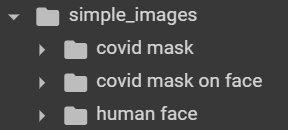

### image label (CVAT)

โหลดภาพจากโฟลเดอร์ simple_images ที่มีภาพคนที่ใส่หน้ากากเท่านั้น ตรวจสอบภาพที่ไม่ต้องการหรือซ้ำด้วย ตัวอย่างนี้ใช้ 52 ภาพ

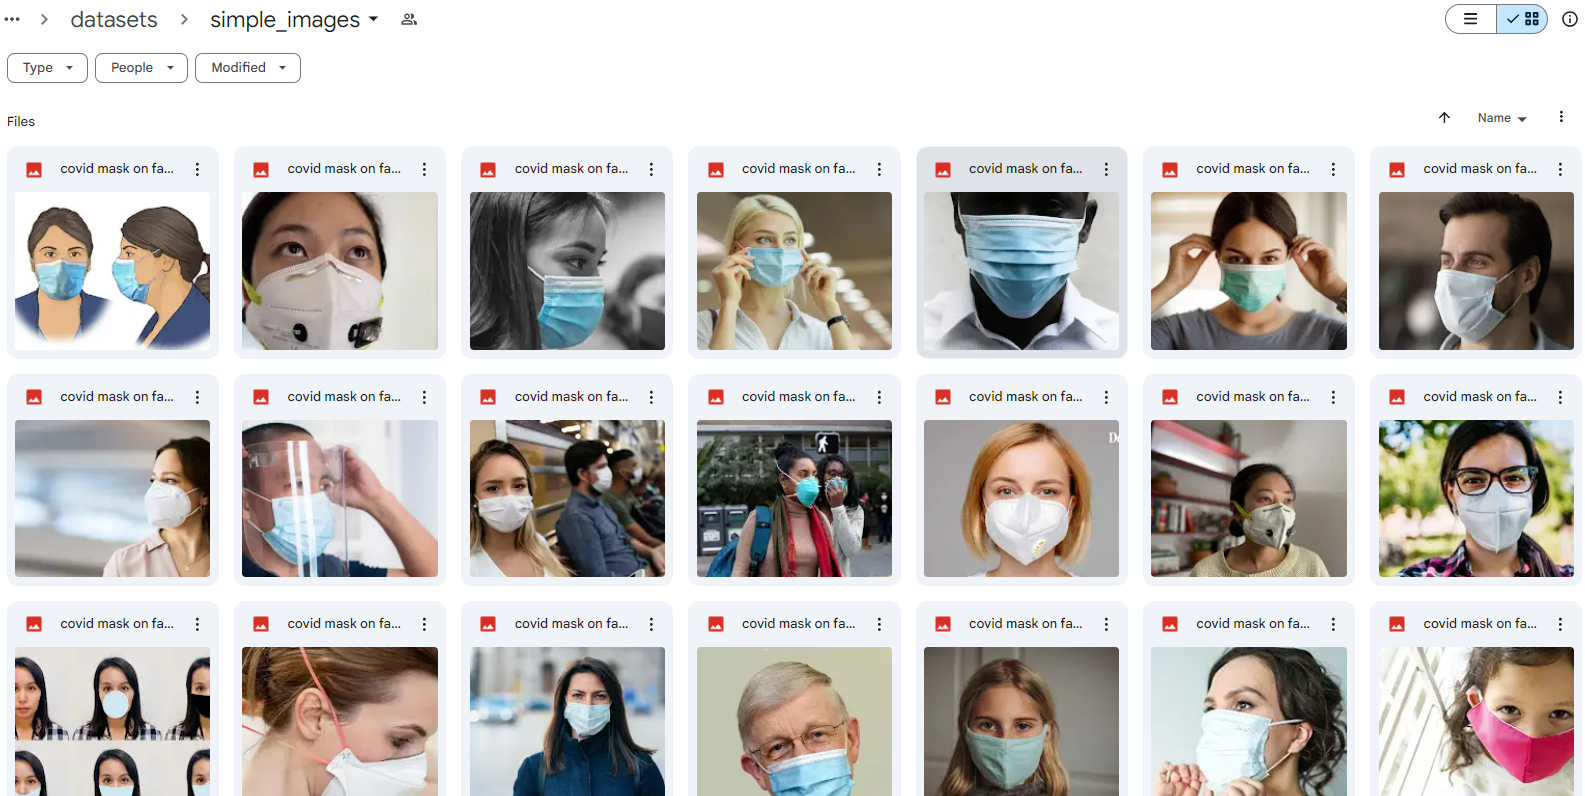

จากนั้นเข้าเว็บ CVAT

- create new project ชื่อไรก็ได้, ใส่ label 3 คลาส ได้แก่ mask, face, eye

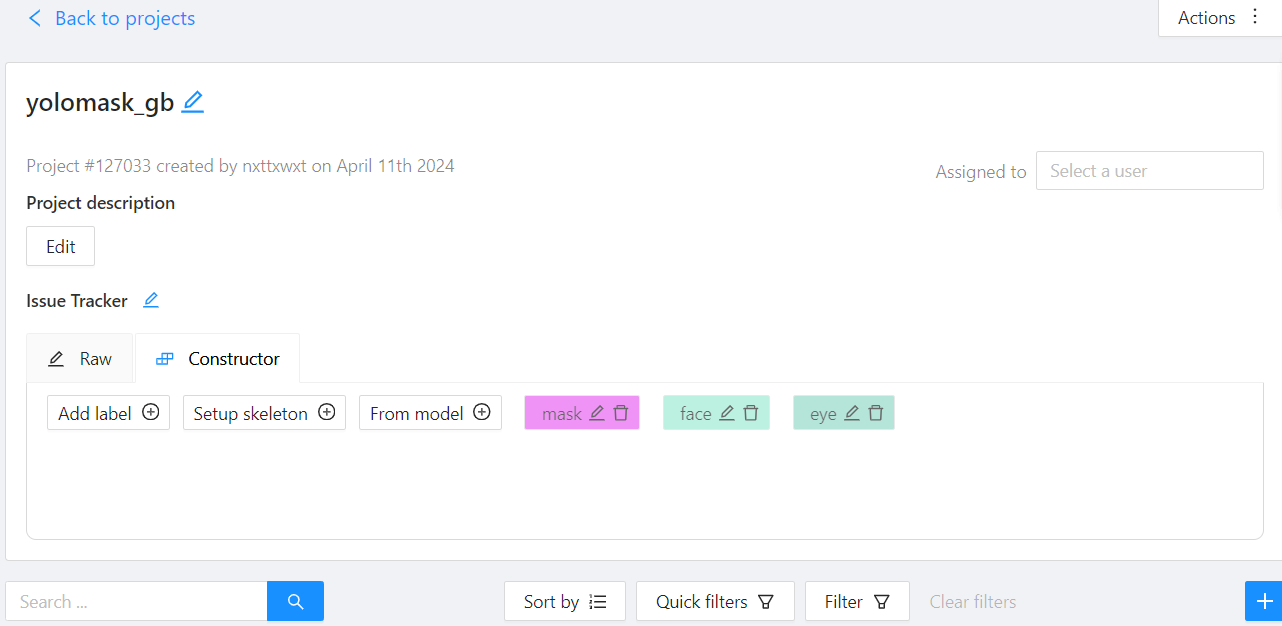

- คลิกเข้า project, create new task เพื่องาน image label
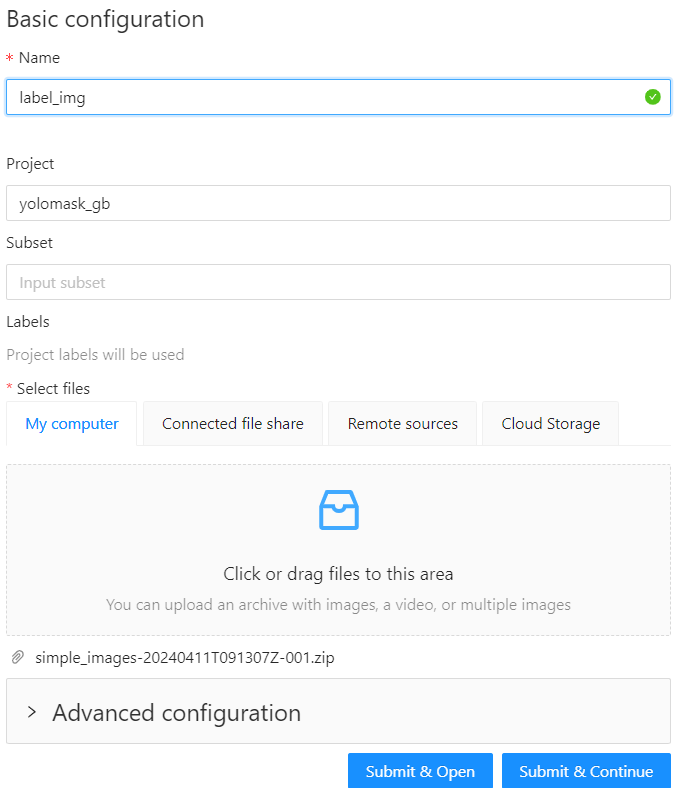

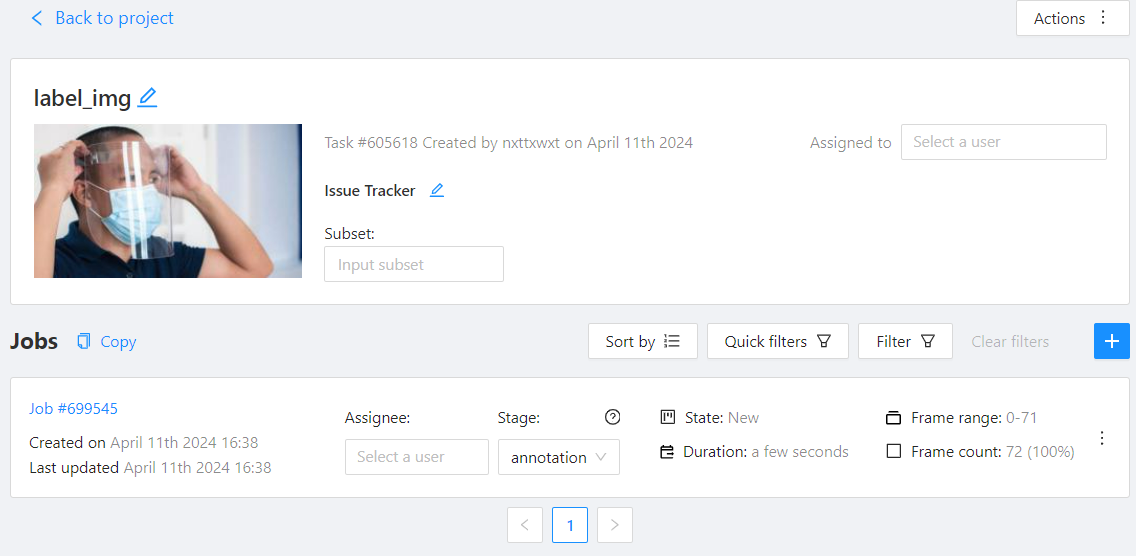

- คลิกไปที่ job แล้วเข้าไปตีกรอบ 4 เหลี่ยม แต่ละองค์ประกอบในภาพ ให้ครบทุกคลาส ทำให้ครบทุกภาพ

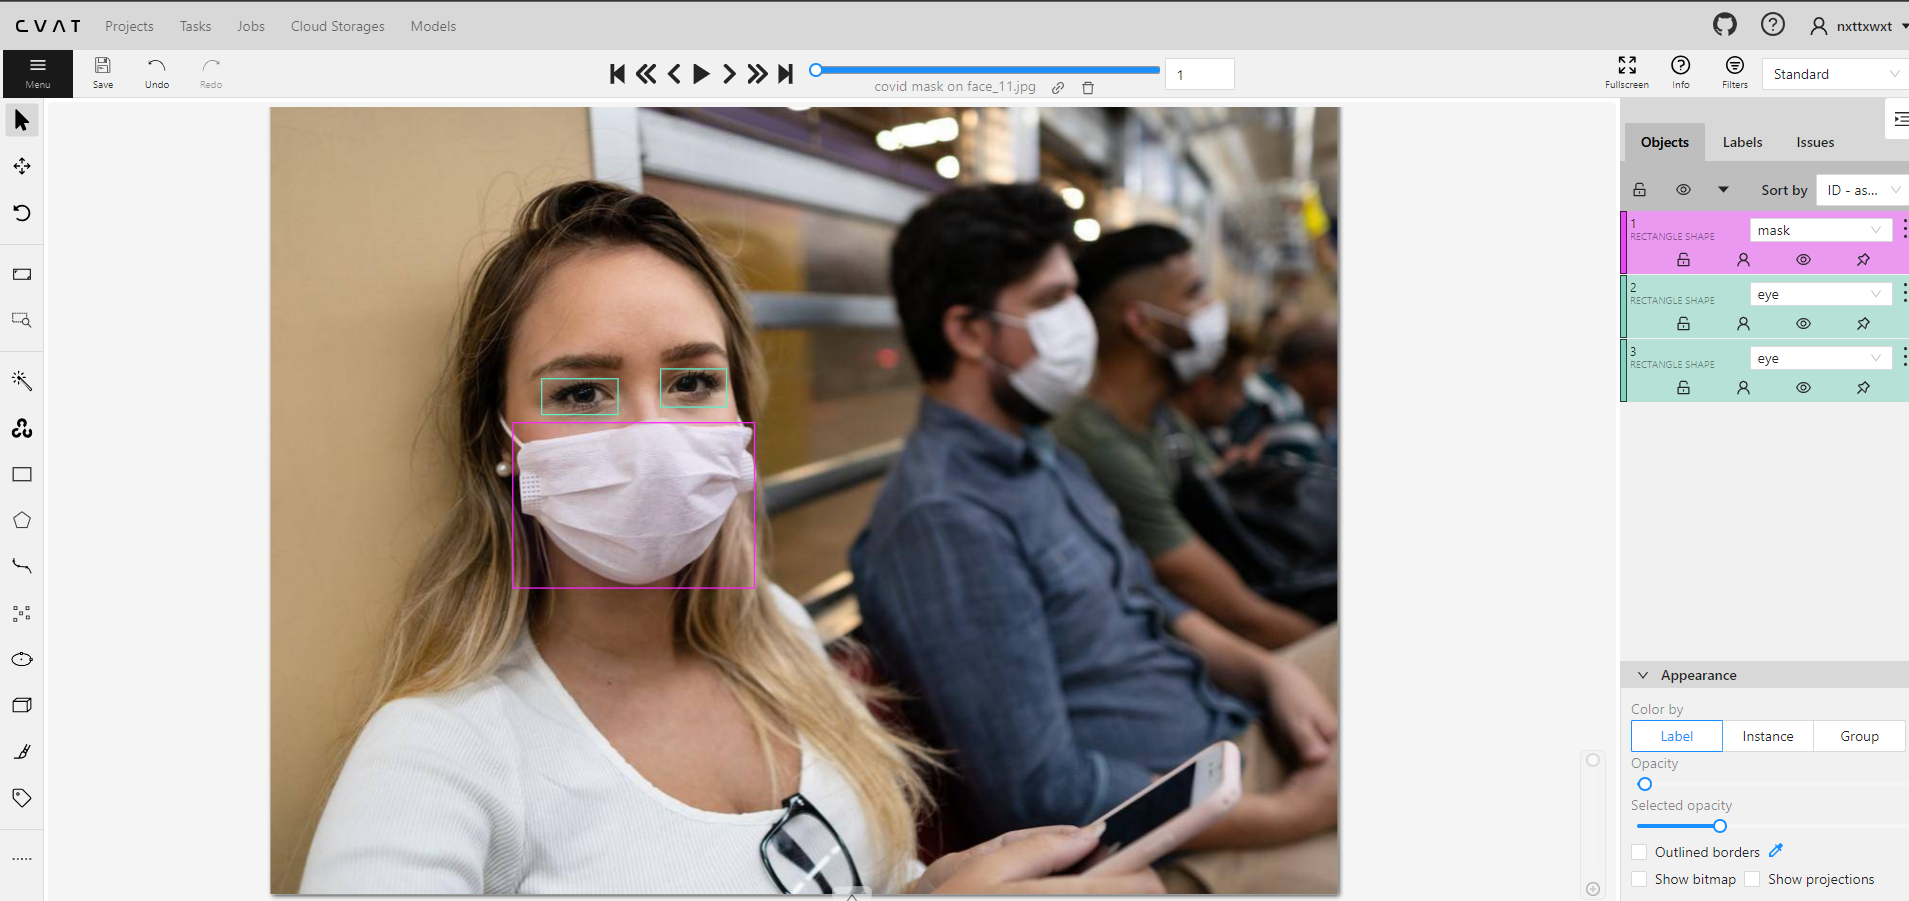

- ทำเสร็จแล้วให้ export task dataset ที่ job ของเรา, เลือก format เป็น YOLO ตั้งชื่อว่า mark_face.zip

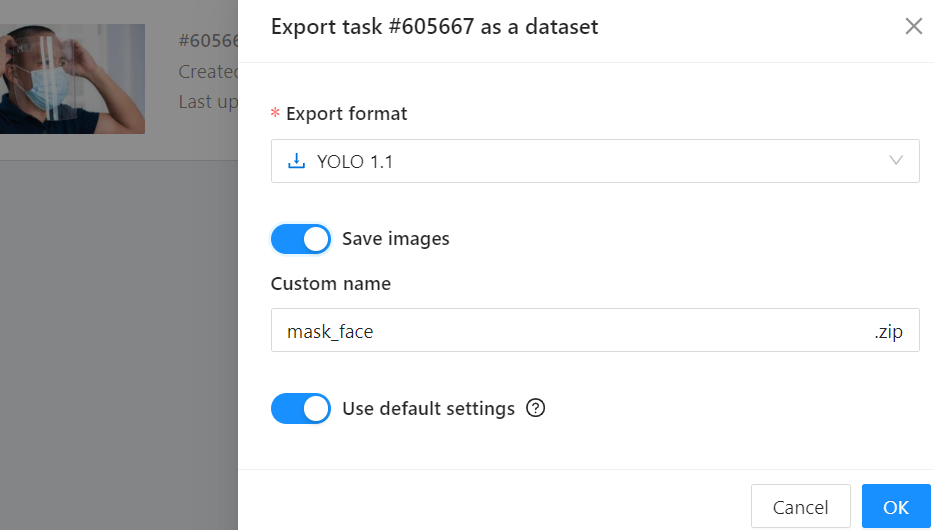

(ในทางปฏิบัติ มีไฟล์เยอะไป export ไม่ได้ ต้องซื้อ premium -> จึงเลือกแบบไม่ save images แล้ว backup data)

จัดโครงสร้างโฟลเดอร์ให้ได้ตามนี้ แล้วค่อย zip

- mask_face
  - images
    - img_1.jpg
    - img_2.jpg
    - ...
  - labels
    - lb_1.txt
    - lb_1.jpg
    - ...

เนื่องจากจำนวน dataset ไม่เยอะ จึงไม่ต้องสร้างโฟลเดอร์ train test val ก็ได้ ให้เป็น train ทั้งหมดเลย เดี้ยวระบบจะแบ่งข้อมูลบางส่วนเป็น val เอง

## setup ก่อน train

In [ ]:
!nvidia-smi   # ตรวจสอบ environment ของ GPU

ใช้ GPU ซะนะ

In [ ]:
import torch

print(f"Setup Complete: Using torch {torch.__version__}")
print(f"{torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'}")

In [ ]:
!git clone https://github.com/ultralytics/yolov5    # ทำการ Clone

In [ ]:
%pip install -qr requirements.txt   # install dependencies

**ตั้งค่ารายละเอียดคลาส**
- เปิดไฟล์ obj.names ที่ได้จาดการ export task dataset ใน CVAT

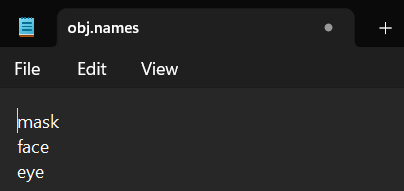

- download ไฟล์ coco.yaml ของ yolov5 แล้วแก้ชื่อเป็น cocomask.yaml แก้ไขรายละเอียดตามนี้

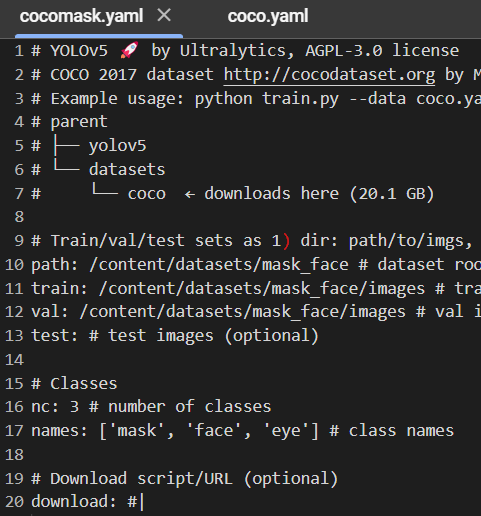

ตรง download ใส่เป็น comment ไปเลย

จากนั้นอัป cocomask.yaml ลงไปในที่เดียวกับที่ copy ไฟล์ coco.yaml

เอาไฟล์ mask_face.zip ที่ทำใน CVAT มาปลด zip

In [ ]:
!unzip "/content/drive/MyDrive/deep_greenbook/datasets/mask_face.zip" -d "/content/datasets"    # -d คือ unzip to directory

## ลงมือ Train

เริ่ม Train โดยกำหนดค่าพารามิเตอร์ได้กล่าวไปแล้ว
- data: ใช้ cocomask.yaml
- img: กำหนดขนาด image ซัก 400 ลดลงได้เพื่อลดเวลาเทรน (ตอนนำ Model ไปใช้งานต้องกำหนดขนาดเท่ากับที่ Train)
- weights: ไฟล์ weight ในที่นี้ไม่ได้กำหนด ก็คือเริ่มจากศูนย์
- batch-size: ลองใช้ 32 ถ้า error ก็ลดลงเหลือ 16 8 ...
- epoches: ควรลองค่าน้อยๆก่อน อย่าง 40 จากนั้นลองประมาณ 200-300 epochs
- name: ชื่อ model

ถ้าตั้งค่าตามนี้แล้วใช้ GPU จะใช้เวลาประมาณ 6 นาที

ตอน run อย่าเสือกกด tab ที่ค่าพารามิเตอร์เพื่อจะคอมเม้น ไม่งั้น run ไม่ได้

In [ ]:
# ทำการ train
!python /content/yolov5/train.py --data /content/yolov5/data/cocomask.yaml --cfg /content/yolov5/models/yolov5s.yaml --weights /content/yolov5s.pt --batch-size 32 --epochs 40 --img 400 --name mask_mo

- ค่า mAP (Mean Average Precision) รวม (all) คือผลประเมินรวมทุกคลาส คือ 0.667 = 66.7%
- P (Precision), R (Recall) รวม (all) ขณะนี้คือ 0.613 และ 0.688 ตามลำดับ คือประมาณ 61.3% และ 68.8%

ขณะ Train จะมีการบันทึกผลการเทรน (Log) คล้ายๆกับ history: Accuracy และ Loss ของ NN -> เปิดดูได้ที่ Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/train/mask_mo4

ค่าความแม่นยำตอนนี้ยังไม่สูงมาก ใช้ไม่ค่อยได้ ลอง train ต่ออีกหน่อย

In [ ]:
# ใช้ค่า weight ที่เจ๋งที่สุดของอันที่แล้ว
!python /content/yolov5/train.py --data /content/yolov5/data/cocomask.yaml --cfg /content/yolov5/models/yolov5s.yaml --weights /content/yolov5/runs/train/mask_mo4/weights/best.pt --batch-size 32 --epochs 160 --img 400 --name mask_mo

**สรุปผลประเมิน**
- ค่า mAP (Mean Average Precision) รวม (all) คือผลประเมินรวมทุกคลาส คือ 0.987 = 98.7%
- P (Precision), R (Recall) รวม (all) ขณะนี้คือ 0.982 และ 0.97 ตามลำดับ คือประมาณ 98.2% และ 97%
- ค่าความแม่นยำรวมดูเหมือนจะสูง ทั้งนี้จำนวน Dataset ยังถือว่ามีน้อยมาก ดังนั้นเวลานำไปใช้จริง อาจยังไม่แม่นยำเท่าที่ควร

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/train/mask_mo5

YOLO มีกระบวนการประมวลภาพทำ Augmentation ให้สำหรับการ Train สามารถดูภาพดังกล่าวได้ที่ ../runs/train/mask_mo/train_batch[ใส่เลขที่ต้องการ].jpg

In [ ]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/train/mask_mo5/train_batch0.jpg', width=600)

In [ ]:
Image(filename='/content/yolov5/runs/train/mask_mo5/train_batch1.jpg', width=600)

ไฟล์ val_batch.._labels แสดง label ของภาพ ส่วนไฟล์ val_batch.._pred จะแสดงผลการประเมิน (Validation)

In [ ]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/train/mask_mo5/val_batch0_labels.jpg', width=600)

In [ ]:
Image(filename='/content/yolov5/runs/train/mask_mo5/val_batch0_pred.jpg', width=600)

## การใช้งาน

เมื่อได้ผลที่น่าพอใจ ก็นำไป predict, โดยหลังจาก Train จะได้ weight ชื่อ best.pt อยู่ใน runs/train/exp/weights/ ให้นำไฟล์นี้ไปใช้ โดยสั่งรันไฟล์ detect.py ระบุพารามิเตอร์ weights (ที่ train เสร็จแล้ว)

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/mask_mo5/weights/best.pt --img 400 --conf 0.3 --source /content/drive/MyDrive/deep_greenbook/image/artsaimask.jpg

runs/detect/mask_mo -> โฟลเดอร์ที่เก็บภาพ predict แล้ว

หลังตรวจจับ ระบบจะเก็บภาพ (ที่ตีกรอบ) ไว้ในโฟลเดอร์ runs/detect/mask_mo โหลดมาดูได้ตามนี้

In [ ]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp/artsaimask.jpg', width=400)

แล้วสั่งตรวจจับทั้งโฟลเดอร์โดยกำหนด resource ให้ชี้ไปที่โฟลเดอร์เก็บภาพทดสอบ ดังนี้

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/mask_mo5/weights/best.pt --img 400 --conf 0.3 --source /content/datasets/mask_face/images/

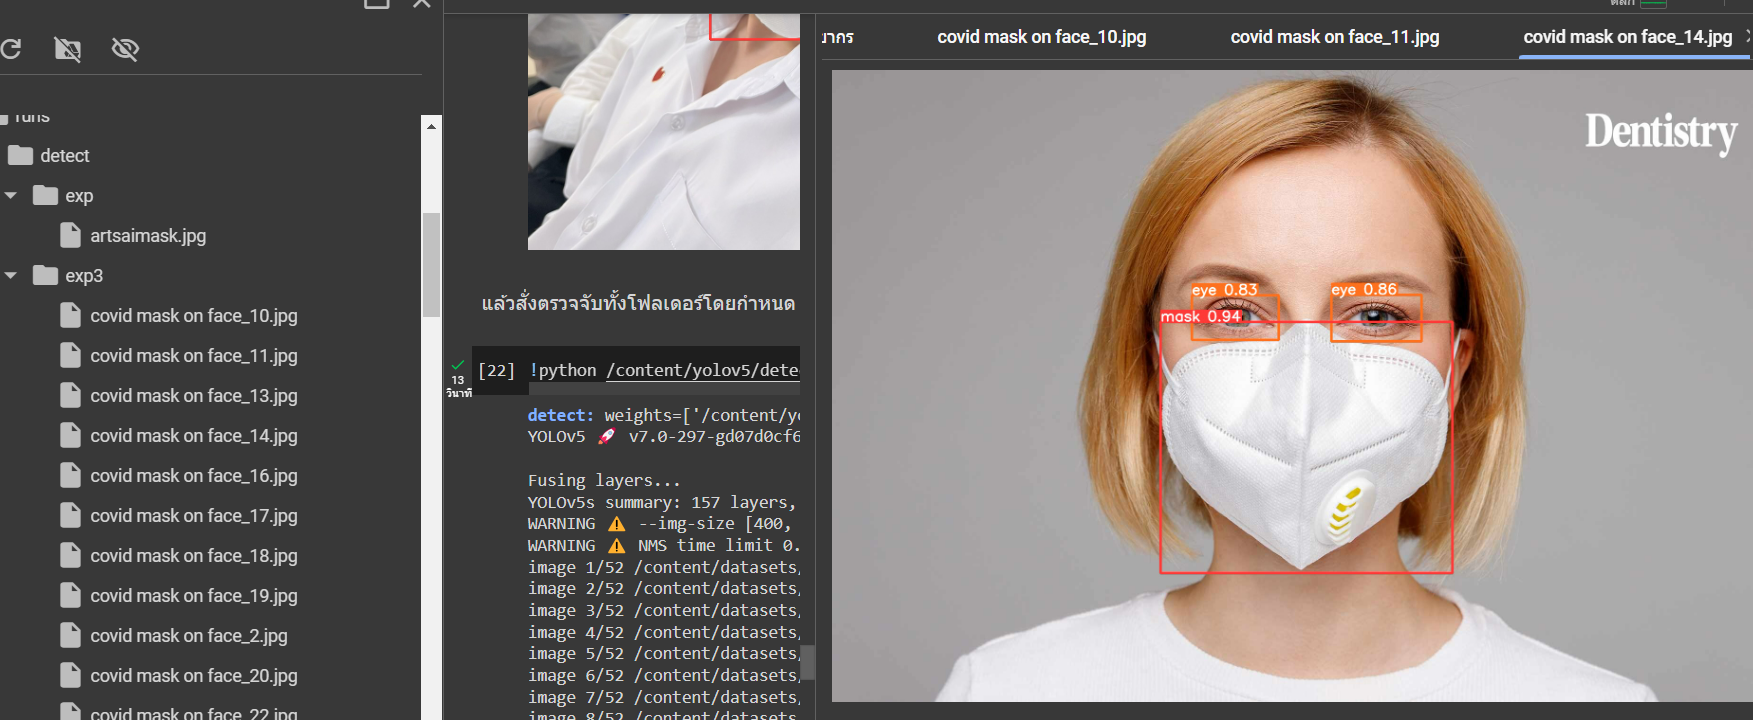

# (12.) Image Segmentation

โหลด dataset จากที่นี่ => https://www.robots.ox.ac.uk/~vgg/data/pets/

เขียนโค้ด ลอกจากที่นี่ => https://github.com/alnbvy/OxfordPets_Unet/blob/main/OxfordPets_UNet.ipynb